In [23]:
# Import necessary libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

from neurodiffeq import diff
from neurodiffeq.conditions import IVP, DirichletBVP, DirichletBVP2D
from neurodiffeq.solvers import Solver1D, Solver2D
from neurodiffeq.networks import FCNN, SinActv
from neurodiffeq.monitors import Monitor1D, Monitor2D
from neurodiffeq.generators import Generator1D, Generator2D

from scipy.integrate import solve_ivp

In [63]:
alpha = 2
def VDP(x, y, t):
    return [diff(x, t)-y, diff(y, t)-alpha*(1-x**2)*y - x]

ivbc = [IVP(t_0=0, u_0=2.0), IVP(t_0=0, u_0=0.0)]

x_range = [0., 5.]

In [64]:
def VanDerPols(t, y, alpha):
    if isinstance(y, np.ndarray):
        yp = np.ones_like(y)
        yp[0] = y[1]
        yp[1] = alpha*(1-y[0]**2)*y[1] - y[0]
    else:
        yp = torch.ones_like(y)
        yp[:, 0, :] = y[:, 1, :]
        yp[:, 1, :] = alpha*(1-y[:, 0, :]**2)*y[:, 1, :] - y[:, 0, :]
    return yp

v = np.array([[2.], [0.0]])

true_func = lambda x, v: solve_ivp(lambda t, y: VanDerPols(t, y, alpha=alpha), [x_range[0], x_range[1]],
                                   v.squeeze(), t_eval=x.squeeze(),
                                   method="Radau").y

Training Progress:   0%|          | 0/100000 [00:00<?, ?it/s]

Training Progress:  10%|▉         | 9998/100000 [04:18<42:13, 35.53it/s]  

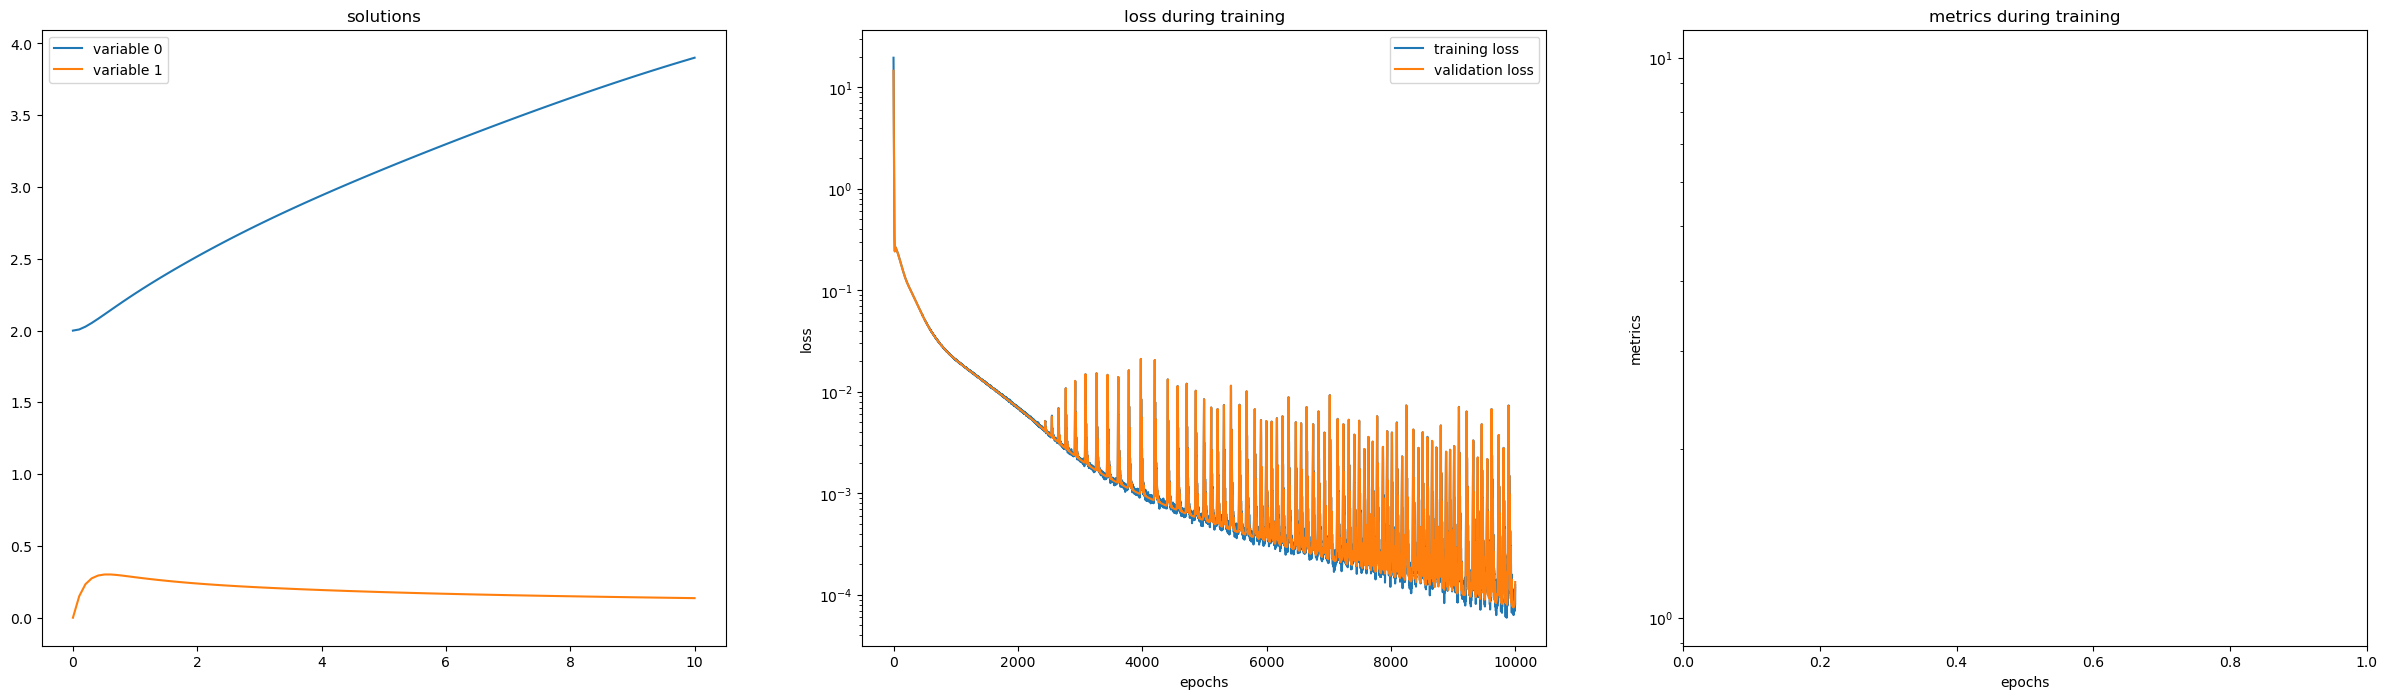

Training Progress: 100%|██████████| 100000/100000 [49:34<00:00, 33.62it/s] 


In [65]:
# Define the monitor callback
monitor=Monitor1D(check_every=10000, t_min=0, t_max=10)
monitor_callback = monitor.to_callback()

# Instantiate the solver
solver = Solver1D(
    ode_system=VDP,
    conditions=ivbc,
    train_generator=Generator1D(512, 0, 10, method='equally-spaced-noisy'),
    valid_generator=Generator1D(512, 0, 10, method='equally-spaced')
)

# Fit the neural network
solver.fit(max_epochs=100000, callbacks=[monitor_callback])
solution = solver.get_solution()

In [68]:
solver.loss

AttributeError: 'Solver1D' object has no attribute 'loss'

In [66]:
t = np.linspace(0, 5, 100)
[x, y] = solution(t, to_numpy=True)

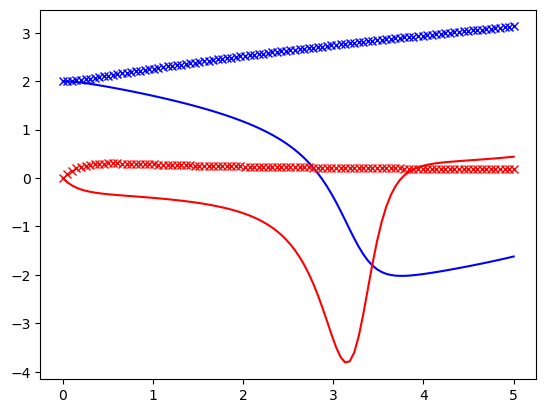

In [67]:
fig, ax = plt.subplots()

ax.plot(t, x, 'x', markersize=6, color='b')
ax.plot(t, true_func(t, v)[0], markersize=8, color='b')

ax.plot(t, y, 'x', markersize=6, color='r')
ax.plot(t, true_func(t, v)[1], markersize=8, color='r')
